### Никишев И.О. 224-321 Лабораторная работа №3 Анализ точности работы алгоритмов дебайеризации
Цель

Оценить влияния параметров дебайеризации на точность передачи
изображения с помощью показателей качества изображений и цветового
различия.

Исходное изображение для применения алгоритмов дебайеризации - фотография тест-объекта X-rite ColorChecker. Для деюайеризации необходимо использовать фильтр GRBG

<img src="GRBG.png" width="240">

Изображение с верными значениями цветовых каналов:

<img src="ColorChecker.png" width="240">

1. Провести дебайеризацию изображения GRBG.png двумя методами:
SuperPixel и билинейной интерполяцией используя фильтр GRBG.
2. Для изображения, полученного с помощью SuperPixel, увеличить
разрешение изображения методом ближайшего соседа, таким образом чтобы оно по размеру в пикселях совпало с исходным изображением ColorChecker.png

### SuperPixel
SuperPixel - Самый простой из алгоритмов, суть которого заключается в последовательном считывании групп по четыре пикселя (матрицы 2 на 2) и записи значений с красного и синего элементов в соответствующий канал, а значение для зеленого усредняется из двух.

<Figure size 4000x6000 with 0 Axes>

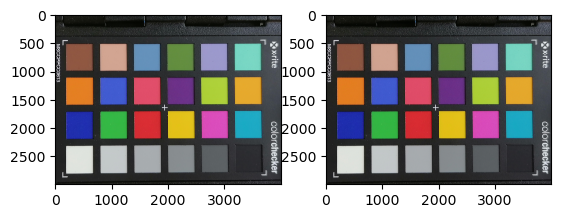

In [2]:
import cv2, numpy as np, matplotlib.pyplot as plt
img =cv2.imread('GRBG.png')

#Для выполнения работы с помощью программного кода должна быть создана функция выполняющая дебайеризацию.
def debayering(image,bayer_filter,alg):
    if len(image.shape)==3: image = image[:,:,0].astype(int) # Удаление лишних каналов, т.к изображение чёрно белое
    r,g,b = [],[],[] # списки с пикселями каждого цвета

    if alg=='SuperPixel':
        # Считывание групп по 4 пикселя
        groups = []
        groups.append(image[::2,::2]) # 1 пиксель каждой группы
        groups.append(image[1::2,::2]) # 2 пиксель каждой группы, и т.д.
        groups.append(image[::2,1::2])
        groups.append(image[1::2,1::2])
        d_image = np.zeros(shape = (*groups[0].shape, 3)) # Создаётся новое изображение с 3 цветовыми каналами
        
        for i, v in enumerate(bayer_filter):
            if v=='R':r.append(groups[i])
            if v=='G':g.append(groups[i])
            if v=='B':b.append(groups[i])
        
        d_image[:,:,0] = np.average(r, axis=0) # берётся среднее значение списка (для цвета которого два в фильтре в данном случае зелёного)
        d_image[:,:,1] = np.average(g, axis=0)
        d_image[:,:,2] = np.average(b, axis=0)
        return np.repeat(np.repeat(d_image.astype(np.uint8), 2, axis=0), 2, axis=1) # увеличение разрешения до размера ColorChecker.png методом ближайшего соседа
    
    if alg=='Билинейная интерполяция':
        res = np.zeros(shape = (*image.shape, 3), dtype=int) # Создаётся новое изображение с 3 цветовыми каналами
        for y in range(0,len(image)-1):
            for x in range(0,len(image[0])-1):
                try:
                    xr=x
                    yr=y
                    if xr%2==0 and yr%2==1: # красный канал
                        res[y,x,0] = image[y,x] # сам канал - значение пикселя
                        res[y,x,1] = (image[y,x+1] + image[y,x-1] + image[y+1,x] + image[y-1,x])/4 # другие каналы - соседние пиксели
                        res[y,x,2] = (image[y+1,x+1] + image[y+1,x-1] + image[y-1,x+1] + image[y-1,x-1])/4
                    elif (xr%2==0 and yr%2==0):
                        res[y,x,2] = (image[y,x+1] + image[y,x-1])/2
                        res[y,x,1] = image[y,x]
                        res[y,x,0] = (image[y+1,x] + image[y-1,x])/2
                    elif (xr%2==1 and yr%2==1): # зелёный канал
                        res[y,x,0] = (image[y,x+1] + image[y,x-1])/2
                        res[y,x,1] = image[y,x]
                        res[y,x,2] = (image[y+1,x] + image[y-1,x])/2
                    elif xr%2==1 and yr%2==0: # синий канал
                        res[y,x,0] = (image[y+1,x+1] + image[y+1,x-1] + image[y-1,x+1] + image[y-1,x-1])/4
                        res[y,x,1] = (image[y,x+1] + image[y,x-1] + image[y+1,x] + image[y-1,x])/4
                        res[y,x,2] = image[y,x]
                    else: print('?')
                except [IndexError, ValueError]: pass
        return res.astype(np.uint8)

        
reference = cv2.cvtColor(cv2.imread('ColorChecker.png'), cv2.COLOR_BGR2RGB)
SuperPixel = debayering(img.copy(),'GRBG','SuperPixel')
plt.figure(figsize = (40,60))
a, b = plt.subplots(1,2)
b[0].imshow(reference)
b[1].imshow(SuperPixel)
#cv2.imwrite('SuperPixel.png',cv2.cvtColor(SuperPixel, cv2.COLOR_RGB2BGR),)

### Билинейная интерполяция

Принцип работы этого алгоритма заключается в получении информации о цвете из соседних элементов. Если мы обрабатываем красный
элемент, то его значение записывается в красный канал, а значения для
синего и зеленого каналов рассчитываются путем усреднения четырех соседних элементов соответствующего цвета. Аналогично для синего пикселя. При обработке зеленого — усредняется по два соседних элемента
других цветов.

<Figure size 4000x6000 with 0 Axes>

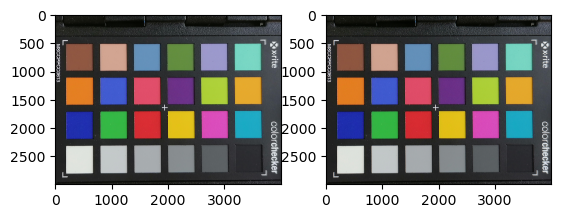

In [3]:
Bilinear = debayering(img.copy(), 'GRGB', 'Билинейная интерполяция')

plt.figure(figsize = (40,60))
a, b = plt.subplots(1,2)
b[0].imshow(reference)
b[1].imshow(Bilinear)
# cv2.imwrite('Bilinear.png', cv2.cvtColor(Bilinear, cv2.COLOR_RGB2BGR))

3. Сравнить полученные изображения и ColorChecker.png с помощью
MSE, PSNR и SSIM и заполнить таблицу

In [4]:
# Метрики MSE, PSNR и SSIM
def mse(image1, image2):
    return np.sum((np.abs(image1.astype(float) - image2.astype(float)))**2) / image1.size
def psnr(image1, image2):
    import math
    return 20 * math.log10(255/(mse(image1, image2)**0.5))
from skimage.metrics import structural_similarity as ssim

print(f'SuperPixel')
print(f'MSE = {mse(SuperPixel, reference)}')
print(f'PSNR = {psnr(SuperPixel, reference)}')
print(f'SSIM = {ssim(SuperPixel, reference,channel_axis=2)}')
print()
print(f'Билинейная интерполяция')
print(f'MSE = {mse(Bilinear, reference)}')
print(f'PSNR = {psnr(Bilinear, reference)}')
print(f'SSIM = {ssim(Bilinear, reference,channel_axis=2)}')

SuperPixel
MSE = 17.525145555555557
PSNR = 35.69418727170037
SSIM = 0.9347193320771664

Билинейная интерполяция
MSE = 18.916157944444443
PSNR = 35.36247429276145
SSIM = 0.9497024232303458


| Изображение             | MSE    | PSNR  | SSIM |
| ----------------------- | ------ | ----- | ---- |
| SuperPixel              | 17.52  | 35.7  | 0.93 |
| Билинейная интерполяция | 18.91 | 32.36 | 0.94 |

4. Получить усредненные координаты RGB для пяти полей на тестобъекте: одного серого и четырех цветных, выбранных произволь2
но, на исходном изображении ColorChecker.png и после дебайеризации. Затем рассчитать координаты Lab.

In [10]:
orange = np.s_[1134:1582, 227:653]
lime = np.s_[1134:1582, 2607:3036]
blue = np.s_[1740:2175, 223:630]
red = np.s_[1726:2175, 1424:1856]
black = np.s_[2322:2767, 3215:3638]
import colormath.color_objects, colormath.color_conversions, colormath.color_diff
orange_ref = colormath.color_objects.sRGBColor(*np.average(reference[orange], axis=(0,1)))
lime_ref = colormath.color_objects.sRGBColor(*np.average(reference[lime], axis=(0,1)))
blue_ref = colormath.color_objects.sRGBColor(*np.average(reference[blue], axis=(0,1)))
red_ref = colormath.color_objects.sRGBColor(*np.average(reference[red], axis=(0,1)))
black_ref = colormath.color_objects.sRGBColor(*np.average(reference[black], axis=(0,1)))
orange_sp = colormath.color_objects.sRGBColor(*np.average(SuperPixel[orange], axis=(0,1)))
lime_sp = colormath.color_objects.sRGBColor(*np.average(SuperPixel[lime], axis=(0,1)))
blue_sp = colormath.color_objects.sRGBColor(*np.average(SuperPixel[blue], axis=(0,1)))
red_sp = colormath.color_objects.sRGBColor(*np.average(SuperPixel[red], axis=(0,1)))
black_sp = colormath.color_objects.sRGBColor(*np.average(SuperPixel[black], axis=(0,1)))
orange_b = colormath.color_objects.sRGBColor(*np.average(Bilinear[orange], axis=(0,1)))
lime_b = colormath.color_objects.sRGBColor(*np.average(Bilinear[lime], axis=(0,1)))
blue_b = colormath.color_objects.sRGBColor(*np.average(Bilinear[blue], axis=(0,1)))
red_b = colormath.color_objects.sRGBColor(*np.average(Bilinear[red], axis=(0,1)))
black_b = colormath.color_objects.sRGBColor(*np.average(Bilinear[black], axis=(0,1)))
print('RGB:')
print(f'Оранжевый - оригинал = {orange_ref}; SuperPixel - {orange_sp}; Билинейная интерполяция: {orange_b}')
print(f'Светло зелёный - оригинал = {lime_ref}; SuperPixel - {lime_sp}; Билинейная интерполяция: {lime_b}')
print(f'синий - оригинал = {blue_ref}; SuperPixel - {blue_sp}; Билинейная интерполяция: {blue_b}')
print(f'Красный - оригинал = {red_ref}; SuperPixel - {red_sp}; Билинейная интерполяция: {red_b}')
print(f'Чёрный - оригинал = {black_ref}; SuperPixel - {black_sp}; Билинейная интерполяция: {black_b}')

RGB:
Оранжевый - оригинал = sRGBColor (rgb_r:228.5972 rgb_g:127.2268 rgb_b:35.3803); SuperPixel - sRGBColor (rgb_r:226.9397 rgb_g:125.3711 rgb_b:33.7203); Билинейная интерполяция: sRGBColor (rgb_r:226.7084 rgb_g:125.3883 rgb_b:33.5031)
Светло зелёный - оригинал = sRGBColor (rgb_r:173.6240 rgb_g:208.1454 rgb_b:57.2254); SuperPixel - sRGBColor (rgb_r:172.0073 rgb_g:206.3378 rgb_b:55.6190); Билинейная интерполяция: sRGBColor (rgb_r:171.7871 rgb_g:206.3454 rgb_b:55.4092)
синий - оригинал = sRGBColor (rgb_r:32.3420 rgb_g:46.9060 rgb_b:174.4692); SuperPixel - sRGBColor (rgb_r:30.6980 rgb_g:45.0532 rgb_b:172.8322); Билинейная интерполяция: sRGBColor (rgb_r:30.4736 rgb_g:45.0674 rgb_b:172.6227)
Красный - оригинал = sRGBColor (rgb_r:215.2304 rgb_g:45.1825 rgb_b:51.4004); SuperPixel - sRGBColor (rgb_r:213.6036 rgb_g:43.3562 rgb_b:49.7631); Билинейная интерполяция: sRGBColor (rgb_r:213.3563 rgb_g:43.3656 rgb_b:49.5592)
Чёрный - оригинал = sRGBColor (rgb_r:44.0179 rgb_g:44.1833 rgb_b:48.4078); Sup

Функции расчета координат Lab и цветового различия 𝛿𝐸76 из курса «Обработка изображений», практическое занятие 1.

In [11]:
lab = lambda x: (colormath.color_conversions.convert_color(x, colormath.color_objects.LabColor).lab_l/100, colormath.color_conversions.convert_color(x, colormath.color_objects.LabColor).lab_a/100, colormath.color_conversions.convert_color(x, colormath.color_objects.LabColor).lab_b/100)
import math
def e76(lab1, lab2):
    l1, a1, b1 = lab1.get_value_tuple()
    l2, a2, b2 = lab2.get_value_tuple()
    return round(((l1 - l2) ** 2 + (a1 - a2) ** 2 + (b1 - b2) ** 2)**(0.5), 2)
print('Lab:')
print(f'Оранжевый - оригинал = {lab(orange_ref)}; SuperPixel - {lab(orange_sp)}; Билинейная интерполяция: {lab(orange_b)}')
print(f'Светло зелёный - оригинал = {lab(lime_ref)}; SuperPixel - {lab(lime_sp)}; Билинейная интерполяция: {lab(lime_b)}')
print(f'синий - оригинал = {lab(blue_ref)}; SuperPixel - {lab(blue_sp)}; Билинейная интерполяция: {lab(blue_b)}')
print(f'Красный - оригинал = {lab(red_ref)}; SuperPixel - {lab(red_sp)}; Билинейная интерполяция: {lab(red_b)}')
print(f'Чёрный - оригинал = {lab(black_ref)}; SuperPixel - {lab(black_sp)}; Билинейная интерполяция: {lab(black_b)}')

print()
print('ΔE:')
print(f'Оранжевый  - SuperPixel - {e76(orange_sp, orange_ref)}; Билинейная интерполяция: {e76(orange_b, orange_ref)};')
print(f'Светло зелёный - SuperPixel - {e76(lime_sp, lime_ref)}; Билинейная интерполяция: {e76(lime_b, lime_ref)};')
print(f'синий - SuperPixel - {e76(blue_sp, blue_ref)}; Билинейная интерполяция: {e76(blue_b, blue_ref)};')
print(f'Красный - SuperPixel - {e76(red_sp, red_ref)}; Билинейная интерполяция: {e76(red_b, red_ref)};')
print(f'Чєрный - SuperPixel - {e76(black_sp, black_ref)}; Билинейная интерполяция: {e76(black_b, black_ref)};')

Lab:
Оранжевый - оригинал = (62.42007556146204, 29.02794161538278, 51.835660963684546); SuperPixel - (61.88749494228116, 29.24685536359089, 51.72336206210839); Билинейная интерполяция: (61.86203816917483, 29.157167213354747, 51.739597093829985)
Светло зелёный - оригинал = (75.37371324067321, -26.19239309262575, 55.710644042293026); SuperPixel - (74.83813648049897, -26.087561106321502, 55.58942745842662); Билинейная интерполяция: (74.82683973534769, -26.173178121501515, 55.626524538534255)
синий - оригинал = (32.58850592149108, 36.829898603338385, -57.57819623650942); SuperPixel - (32.08135724633521, 37.15620483327496, -57.58035039700224); Билинейная интерполяция: (32.05581951994504, 37.08303172804609, -57.51520542395946)
Красный - оригинал = (50.03977914208527, 53.29669844545226, 35.185057808419636); SuperPixel - (49.632164222050015, 53.21440676333278, 35.44130416727757); Билинейная интерполяция: (49.588664053030044, 53.15125530234912, 35.47738740044539)
Чёрный - оригинал = (23.0010617

## Отчёт работы - таблица для сравнения координат цвета и цветового отличия.
:
<img src="Отчёт.png" width="1135">

### Выводы:
Визуально полученные изображения выглядят одинаково, однако если приблизить изображение, полученное методом билинейной интерполяции, можно заметить, что на границах перехода цвета возникает артефакт ложного цвета. На изображениях низкого разрешения это искажение было бы более заметным. С другой стороны, изображение, полученное методом SuperPixel, имеет разрешение в два раза ниже чем оригинальное изображение, что является недостатком по сравнению с билинейной фильтрацией, при которой разрешение сохраняется. Если рассматривать разницу между показателем ΔE76, цвета SuperPixel немного ближе к оригиналу по сравнению с билинейной интерполяцией, однако эта разница минимальна. 